## Importing Modules

In [4]:
import re
import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
import emoji

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from autocorrect import Speller
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
lemmatizer = WordNetLemmatizer()
spell = Speller(lang='en')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Importing Data

In [5]:
data = pd.read_csv('data/data.csv', encoding = "ISO-8859-1",
                    names=["sentiment", "ids", "date", "flag", "user", "text"])

### Balancing Data

Shape of New Dataset:  (4000, 6)
Positive Tweets:  2000
Negative Tweets:  2000


<AxesSubplot:xlabel='sentiment', ylabel='count'>

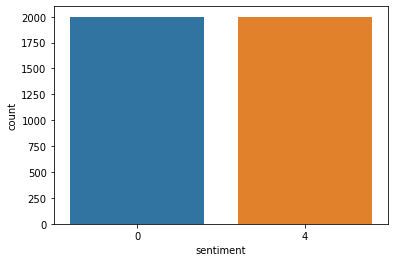

In [6]:
# No of rows to take for training
rows = 2000
positive_tweet = data[data['sentiment']==4][:rows]
negative_tweet = data[data['sentiment']==0][:rows]
df = pd.concat([positive_tweet, negative_tweet])
print("Shape of New Dataset: ", df.shape)
print("Positive Tweets: ", len(df[df['sentiment']==4]))
print("Negative Tweets: ", len(df[df['sentiment']==0]))

sns.countplot(x='sentiment', data=df)

In [7]:
# Lets print unique values in each column
for col in df.columns:
  print('Column Name: ', col)
  #print('Unique Values: ', df[col].unique()[:10])
  print('Count: ', len(df[col].unique()))
  print('--------------------------------')

Column Name:  sentiment
Count:  2
--------------------------------
Column Name:  ids
Count:  3993
--------------------------------
Column Name:  date
Count:  2575
--------------------------------
Column Name:  flag
Count:  1
--------------------------------
Column Name:  user
Count:  3634
--------------------------------
Column Name:  text
Count:  3989
--------------------------------


In [8]:
# As Username date and ids are no use for us in sentiment analysis and flag colume has just one value same for everyone, So we will remove all those columns

# Secondly our target column has {0 (negative), 4 (positive)} we will use 1 for positive sentiment as we are just classifying b/w positive and negative and do not want our model to give any priorities to positive sentiment 

df = df.loc[:, ['text', 'sentiment']]
df['sentiment'] = df['sentiment'].replace(4, 1)
df.head(3)

,text,sentiment
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",1


## Cleaning and Saving Data

In [9]:
from nltk.corpus import stopwords
from collections import Counter

def clean_text(text):
  # Remove Emoji or use emoji.demojize(text) to replace emoji with respective handles 
  text = emoji.replace_emoji(text, replace='')
  # Removes Links
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'www.\S+', '', text)
  # Remove Handles
  text = ' '.join(filter(lambda x: x[0]!='@', text.split()))
  # Remvoe Punctuations
  text = re.sub(r'[^\w\s]', '', text)
  # Remove Digits
  text = re.sub(r'[0-9]+', '', text)
  # Remove @, _
  text = text.replace('#', '').replace('_', '')
  # Removing Stopwords
  stop_words = stopwords.words('english')
  stopwords_dict = Counter(stop_words)
  text = ' '.join({word for word in text.split() if word not in stopwords_dict and len(word)>2})
  # Tokenize Word
  text_tokenized = nltk.word_tokenize(text)
  # Lemmatize with POS Tag
  # text = nltk.pos_tag(nltk.word_tokenize(text))
  # def get_wordnet_pos(word):
  #     """Map POS tag to first character lemmatize() accepts"""
  #     tag = nltk.pos_tag([word])[0][1][0].upper()
  #     tag_dict = {"J": wordnet.ADJ,
  #                 "N": wordnet.NOUN,
  #                 "V": wordnet.VERB,
  #                 "R": wordnet.ADV}
  #     return tag_dict.get(tag, wordnet.NOUN)
  # text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text]
  # Lemmetize Words
  text = [lemmatizer.lemmatize(spell(word)) for word in text_tokenized if len(word)>=2]
  return ' '.join(text)

In [10]:
# Using tqdm to visualize the progress bar while cleaning the dataset
from tqdm.auto import tqdm
tqdm.pandas()
df['text'] = df['text'].progress_apply(clean_text)

# As cleaning the text may get us null values in some tweets
# we will remove them before saving the dataset
df = df.dropna(axis=0, subset=['text'])
# Saving the Preprocessed Dataset
df.to_csv('processed_tweet.csv')

d:\Courses\ML\Projects\Portfolio\portfolio_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 4000/4000 [04:49<00:00, 13.82it/s]


In [11]:
# importing preprcessed dataset
df = pd.read_csv('./processed_tweet.csv', index_col=0, encoding = "ISO-8859-1")
df = df.dropna(axis=0, subset=['text'])
df.head(3)

,text,sentiment
800000,VE best guy,1
800001,one IRL wait meeting Cant besides tonight TALK,1
800002,got Punish area IN Twitter Thanks meet sweethe...,1


### Seperating Postitive and Negative Tweets

In [12]:
# Now Lets create list of words in positive and negative tweets
positive_tweets = df[df['sentiment']==1]
negative_tweets = df[df['sentiment']==0]

pos_tweet_list = positive_tweets['text'].to_list()
neg_tweet_list = negative_tweets['text'].to_list()

pos_list = ('').join(pos_tweet_list).lower()
neg_list = ('').join(neg_tweet_list).lower()

## Visualizing Words in Tweets

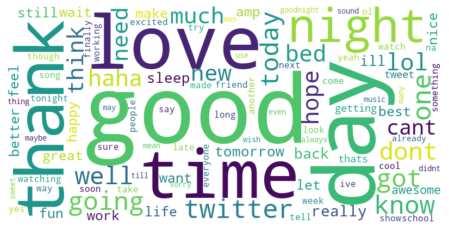

In [14]:
# Wordcloud of Positive Tweets
from wordcloud import WordCloud
wordcloud = WordCloud(max_words=100, background_color='white', width=800, height=400, collocations=False).generate(pos_list)

plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud.to_file('pos_tweet_words.png')

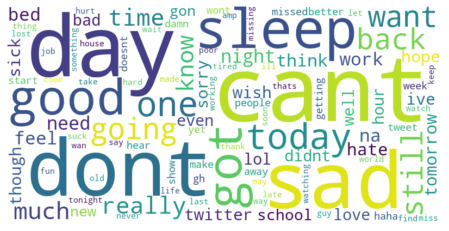

In [15]:
# Wordcloud of Positive Tweets
from wordcloud import WordCloud
wordcloud = WordCloud(max_words=100, background_color='white', width=800, height=400, collocations=False).generate(neg_list)

plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud.to_file('pos_tweet_words.png')

## Splitting Dataset into Train and Test

In [16]:
X = df['text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Initializing Models

In [23]:
# Our Models to Try
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

models = {
  "Logistic Regression": LogisticRegression(),
  "SVM": SVC(),
  "Linear SVM": LinearSVC(),
  "Nearest Centroid": NearestCentroid(),
  "Bernoulli NB": BernoulliNB(), 
  "Complement NB": ComplementNB(), 
  "Multinomial NB": MultinomialNB(), 
  "Preceptron": Perceptron(),
  "KNeighbors Classifier": KNeighborsClassifier(),
  "Random Forest Classifier": RandomForestClassifier(),
  "Bagging Classifier": BaggingClassifier(),
  "Decision Tree Classifier": DecisionTreeClassifier(),
  #"MLP Classifier": MLPClassifier(),
  }

## Training

In [27]:
from tqdm import tqdm
def TextClassifier():
  models_names = []
  accuracies = []
  for model_name, model in tqdm(models.items()):
    vectorizer = CountVectorizer()
    tfidf = TfidfTransformer()
    clf = model

    pipeline = Pipeline([
      ('vec', vectorizer),
      ('tfidf', tfidf),
      ('classifier', clf),
    ])

    pipeline.fit(X_train, y_train)
    accuracy = np.round(pipeline.score(X_test, y_test), 2)
    models_names.append(model_name)
    accuracies.append(accuracy)

  # Creating DataFrame for models and accuracys
  models_scores = pd.DataFrame(list(zip(models_names, accuracies)), columns=['Model Name', 'Accuracy'])
  models_scores = models_scores.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
  return models_scores

TextClassifier()

100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


,Model Name,Accuracy
0,Logistic Regression,0.71
1,SVM,0.71
2,Nearest Centroid,0.70
3,Linear SVM,0.69
4,Bernoulli NB,0.69
5,Random Forest Classifier,0.69
6,Bagging Classifier,0.69
7,Complement NB,0.68
8,Multinomial NB,0.68
9,Preceptron,0.66


### We are getting on average 71% accuracy on basic Logistic Regression model on our dataset considering we just used 4000 tweets instead of 16 million tweets..that seems pretty good...